In [1]:
#
#   ___                  _                
#  / _/______ ____  ____(_)__ _______     
# / _/ __/ _ `/ _ \/ __/ (_-</ __/ _ \    
#/_//_/  \_,_/_//_/\__/_/___/\__/\___/    
# ___ _____(_)__ ___ ____  / /_(_)       
# / _ `/ __/ (_-</ _ `/ _ \/ __/ /        
# \_, /_/ /_/___/\_,_/_//_/\__/_/         
#/___/
#
#Samee Lab @ Baylor College Of Medicine
#francisco.grisanticanozo@bcm.edu

In [2]:
import psutil
import platform
from datetime import datetime

print("="*40, "System Information", "="*40)
uname = platform.uname()
print(f"System: {uname.system}")
print(f"Node Name: {uname.node}")
print(f"Release: {uname.release}")
print(f"Version: {uname.version}")
print(f"Machine: {uname.machine}")

======================================== System Information ========================================
System: Darwin
Node Name: FranciscosMBP2.attlocal.net
Release: 19.6.0
Version: Darwin Kernel Version 19.6.0: Sun Jul  5 00:43:10 PDT 2020; root:xnu-6153.141.1~9/RELEASE_X86_64
Machine: x86_64


In [3]:
#Load libraries
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import sys
import pandas as pd
import warnings
import seaborn as sb
import sklearn
import tqdm
import scanpy as sc
import anndata
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.base import RegressorMixin
from sklearn.base import ClassifierMixin
sc.logging.print_header()

scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.19.1 scipy==1.4.1 pandas==1.1.2 scikit-learn==0.23.2 statsmodels==0.12.0


In [4]:
sys.path.append('../')
from STANN.models import STANN
import STANN.utils as utils

In [5]:
import tensorflow as tf
import tensorflow.keras as keras
print(f'tensorflow=={tf.__version__} \nkeras=={tf.keras.__version__}')

tensorflow==2.2.0 
keras==2.3.0-tf


In [6]:
#Reproducibility
seed = 10
np.random.seed(seed)
tf.random.set_seed(seed)

In [7]:
################LOAD DATA###################

# check to see which data
print("[INFO] loading training data...")
adata_train = sc.read_h5ad("../data/scrna.h5ad")

print("[INFO] loading predict data...")
adata_predict = sc.read_h5ad("../data/seqfish.h5ad")

[INFO] loading training data...
[INFO] loading predict data...


In [8]:
adata_train

AnnData object with n_obs × n_vars = 11684 × 9031
    obs: 'experiment', 'percent_mito', 'n_counts', 'n_genes', 'celltype'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'

In [9]:
X_train, Y_train, X_predict = utils.organize_data(adata_train=adata_train,
                                                  adata_predict=adata_predict)

[INFO] Equal columns = True
[INFO] Data organized


In [10]:
Y_train_dummy,Y_train_ohe,encoder = utils.label_encoder(Y_train=Y_train)

/opt/miniconda3/envs/STANN/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [11]:
class_weights = utils.get_class_weights(Y_train_ohe=Y_train_ohe)
class_weights = {i : class_weights[i] for i in range(15)}
class_weights

/opt/miniconda3/envs/STANN/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14], y=[13  0  8 ...  8 13 13] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 0.6363834422657952,
 1: 0.7629121776036566,
 2: 5.812935323383084,
 3: 6.332791327913279,
 4: 0.7074780502573418,
 5: 6.384699453551913,
 6: 3.042708333333333,
 7: 2.8120336943441635,
 8: 0.3435965299220703,
 9: 0.8457473760405356,
 10: 4.609072978303748,
 11: 2.41155830753354,
 12: 1.320225988700565,
 13: 0.25749862258953166,
 14: 5.9460559796437655}

# Doing train_test after sPCA training

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.base import RegressorMixin
from sklearn.base import ClassifierMixin

   
class BaseSupervisedPCA(object):
    """
    Supervised PCA algorithm proposed by Bair et al. (2006).
    
    
    Parameters
    ----------
    
    fit_intercept : boolean, optional
        whether to calculate the intercept for this model. If set
        to false, no intercept will be used in calculations
        (e.g. data is expected to be already centered).
        
    model : The supervised learning model that will be used to conduct supervised PCA.
    
    Attributes
    ----------
        
    
    References
    ----------
    Bair, Eric, et al. "Prediction by supervised principal components." Journal of the American Statistical Association 101.473 (2006).
    
    """
    
    def __init__(self, fit_intercept=True, model=None,threshold=0,n_components=-1):
        self.fit_intercept = fit_intercept
        self._model=model
        
        self._pca=None
        self._leavouts=None
        self._threshold=threshold
        self._n_components=n_components
        
    def fit(self,X,y):
        """
        Fit the supervised PCA model
        .
        Parameters
        ----------
        X : numpy array or sparse matrix of shape [n_samples,n_features]
            Training data
        y : numpy array of shape [n_samples, n_targets]
            Target values
        threshold : the threshold for the coefficient below which it is discarded.
        n_components : the number of components to keep, after running PCA
        
        Returns
        -------
        self : returns an instance of self.
        """
        
        #these are the columns that will be removed
        self._leavouts=[]        
                
        dummy_X=X[:,np.newaxis]
        
        #test the absolute value of the coefficient for each variable. If it
        #is below a the threshold, then add it to the leaveouts        
        for i in range(0,dummy_X.shape[2]):
            current_X=dummy_X[:,:,i]
            self._model.fit(current_X, y)
            #the all([]) syntax is there in order to support both linear and logistic
            #regression. Logistic regression coefficients for multiclass problems
            #come in multi-dimensional arrays.
            if(all([abs(self._model.coef_[0])<self._threshold])):
                self._leavouts.append(i)
        
        if(len(self._leavouts)==dummy_X.shape[2]):
            raise ValueError('The total number of features to be left out is equal to the total number of features. Please try with a smaller threshold value.')

        
        #delete the variables that were below the threshold
        if(len(self._leavouts)>0):
            dummy_X=np.delete(dummy_X,self._leavouts,2)
        
        #conduct PCA for the designated number of components.
        #If no number was designated (or an illegal value<=0) then use the max number of component
        if(self._n_components>0):
            self._pca = PCA(n_components=self._n_components)
        else:
            self._pca = PCA(n_components=dummy_X.shape[2])
        dummy_X=self._pca.fit_transform(dummy_X[:,0,:])
        
        self._model=self._model.fit(dummy_X,y)
        
        return self
        
    def predict(self,X):
        """Predict using the supervised PCA model
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = (n_samples, n_features)
            Samples.
        Returns
        -------
        C : array, shape = (n_samples,)
            Returns predicted values.        
        """
        #remove the leavouts, transform the data and fit the regression model
        transformed_X=self.get_transformed_data(X)
        return self._model.predict(transformed_X)
    
    def get_transformed_data(self,X):
        """Calculates the components on a new matrix.
        Parameters
        ----------
        X : numpy array or sparse matrix of shape [n_samples,n_features]
            
        Returns
        -------
        transformed_X: Returns a transformed numpy array or sparse matrix. The
        leavouts have been removed and the remaining variables are transformed into
        components using the weights of the PCA object.
        
        Notes
        -------
        The algorithm should have first been executed on a dataset.
        
        """
        transformed_X=np.delete(X,self._leavouts,1)
        transformed_X=self._pca.transform(transformed_X)
        return transformed_X
        
    def get_n_components(self):
        return self._pca.n_components_
    
    
    #I am implementing a function here to get the components in order to avoid
    #the user having to access the pca object. Another option would be to 
    #copy the components from the pca to a variable located at 'self'. However,
    #this might be too redundant.
    
    def get_components(self):
        """Returns the components formerly calculated on a training dataset.
            
        Returns
        -------
        components: A numpy matrix with the loadings of the PCA components.
        
        Notes
        -------
        The algorithm should have first been executed on a dataset.
        
        """
        return self._pca.components_
    
    #same principle as in the get_components function
    def get_coefs(self):
        return self._model.coef_
        
    def score(self,X,y):
        return self._model.score(X,y)
    
        

class SupervisedPCAClassifier(BaseSupervisedPCA,ClassifierMixin):
    """Implementation of supervisedPCA for classification. The underlying model
    is a logistic regression model.
    Parameters
    ----------
    penalty : str, 'l1' or 'l2'
        Used to specify the norm used in the penalization. The newton-cg and
        lbfgs solvers support only l2 penalties.
    dual : bool
        Dual or primal formulation. Dual formulation is only implemented for
        l2 penalty with liblinear solver. Prefer dual=False when
        n_samples > n_features.
    C : float, optional (default=1.0)
        Inverse of regularization strength; must be a positive float.
        Like in support vector machines, smaller values specify stronger
        regularization.
    fit_intercept : bool, default: True
        Specifies if a constant (a.k.a. bias or intercept) should be
        added the decision function.
    intercept_scaling : float, default: 1
        Useful only if solver is liblinear.
        when self.fit_intercept is True, instance vector x becomes
        [x, self.intercept_scaling],
        i.e. a "synthetic" feature with constant value equals to
        intercept_scaling is appended to the instance vector.
        The intercept becomes intercept_scaling * synthetic feature weight
        Note! the synthetic feature weight is subject to l1/l2 regularization
        as all other features.
        To lessen the effect of regularization on synthetic feature weight
        (and therefore on the intercept) intercept_scaling has to be increased.
    class_weight : dict or 'balanced', optional
        Weights associated with classes in the form ``{class_label: weight}``.
        If not given, all classes are supposed to have weight one.
        The "balanced" mode uses the values of y to automatically adjust
        weights inversely proportional to class frequencies in the input data
        as ``n_samples / (n_classes * np.bincount(y))``
    max_iter : int
        Useful only for the newton-cg and lbfgs solvers. Maximum number of
        iterations taken for the solvers to converge.
    random_state : int seed, RandomState instance, or None (default)
        The seed of the pseudo random number generator to use when
        shuffling the data.
    solver : {'newton-cg', 'lbfgs', 'liblinear'}
        Algorithm to use in the optimization problem.
    tol : float, optional
        Tolerance for stopping criteria.
    multi_class : str, {'ovr', 'multinomial'}
        Multiclass option can be either 'ovr' or 'multinomial'. If the option
        chosen is 'ovr', then a binary problem is fit for each label. Else
        the loss minimised is the multinomial loss fit across
        the entire probability distribution. Works only for the 'lbfgs'
        solver.
    verbose : int
        For the liblinear and lbfgs solvers set verbose to any positive
        number for verbosity.
    """
    def __init__(self,fit_intercept=True, normalize=False, copy_X=True,penalty='l2', dual=False, tol=1e-4, C=1.0,
                 intercept_scaling=1, class_weight=None,
                 random_state=None, solver='liblinear', max_iter=100,
                 multi_class='ovr', verbose=0,threshold=0,n_components=-1):
        
        model=LogisticRegression()  
        super(SupervisedPCAClassifier,self).__init__(fit_intercept=fit_intercept,model=model,threshold=threshold,n_components=n_components)
    
    def predict_proba(self,X):
        return self._model.predict_proba(X)

In [13]:
bspca = BaseSupervisedPCA(model=LogisticRegression(multi_class="multinomial",
                                                  class_weight=class_weights,
                                                  solver='lbfgs'),
                          n_components=150)
bspca

In [14]:
%%time

bspca.fit(np.array(X_train),Y_train_dummy)

CPU times: user 1h 14min 23s, sys: 20.4 s, total: 1h 14min 43s
Wall time: 18min 40s


/opt/miniconda3/envs/STANN/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [15]:
X_train_transformed = bspca.get_transformed_data(np.array(X_train))
X_train_transformed

array([[-3.2248759e+00,  3.6289837e+01,  3.3164127e+01, ...,
        -1.9944302e+00, -1.2248203e-02, -8.0418432e-01],
       [-6.4038286e+00, -7.0242376e+00, -7.8395575e-01, ...,
        -6.1357826e-01, -1.2387854e+00,  6.0471691e-02],
       [-8.8336830e+00,  1.0717392e+01, -3.9700937e+00, ...,
        -1.5357304e+00,  1.0292575e+00, -9.8353016e-01],
       ...,
       [ 1.3927888e+02,  1.1558001e+01,  4.6660895e+00, ...,
        -1.3600849e+00,  1.8873371e+00,  1.5902867e+00],
       [-7.2587924e+00, -9.1840172e+00, -9.4207323e-01, ...,
        -3.0210778e-01, -3.3750674e-01, -3.6250845e-01],
       [-9.8358898e+00, -8.7604046e+00, -5.2220976e-01, ...,
         5.4478025e-01,  3.7808028e-01,  2.4498133e-01]], dtype=float32)

In [16]:
x_train, x_test, y_train, y_test = utils.get_train_test_split(X_train_transformed,
                                                    Y_train_ohe,
                                                    test_size=0.10, 
                                                    random_state=40)

[INFO] X_train shape=(10515, 150)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 150)
[INFO] y_test shape=(1169, 15)


In [17]:
model = STANN(act_fun='tanh',
              first_dense=160,
              second_dense=145.0,
              learning_rate=0.01,input_dim=X_train_transformed.shape[1],
              output_dim=len(adata_train.obs.celltype.unique()))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 160)               24160     
_________________________________________________________________
dense_1 (Dense)              (None, 145)               23345     
_________________________________________________________________
dense_2 (Dense)              (None, 15)                2190      
Total params: 49,695
Trainable params: 49,695
Non-trainable params: 0
_________________________________________________________________


In [18]:
#early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='accuracy', 
                                      mode='min', 
                                      verbose=1,
                                      patience=30)

In [21]:
history = model.fit(x_train, 
                    y_train, 
                    validation_split=0.10,
                    epochs=30,
                    class_weight=class_weights,
                    callbacks=[es])

Epoch 1/30
296/296 [==============================] - 0s 2ms/step - loss: 1.1621 - accuracy: 0.6476 - val_loss: 0.7159 - val_accuracy: 0.8375
Epoch 2/30
296/296 [==============================] - 0s 1ms/step - loss: 0.4769 - accuracy: 0.8585 - val_loss: 0.4852 - val_accuracy: 0.8793
Epoch 3/30
296/296 [==============================] - 0s 1ms/step - loss: 0.3404 - accuracy: 0.8942 - val_loss: 0.3797 - val_accuracy: 0.9049
Epoch 4/30
296/296 [==============================] - 0s 1ms/step - loss: 0.2676 - accuracy: 0.9148 - val_loss: 0.3281 - val_accuracy: 0.9163
Epoch 5/30
296/296 [==============================] - 0s 1ms/step - loss: 0.2222 - accuracy: 0.9263 - val_loss: 0.2884 - val_accuracy: 0.9268
Epoch 6/30
296/296 [==============================] - 0s 1ms/step - loss: 0.1894 - accuracy: 0.9359 - val_loss: 0.2607 - val_accuracy: 0.9306
Epoch 7/30
296/296 [==============================] - 0s 1ms/step - loss: 0.1647 - accuracy: 0.9438 - val_loss: 0.2397 - val_accuracy: 0.9373
Epoch 

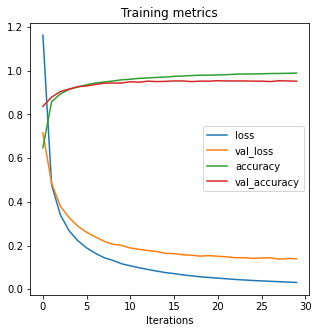

In [22]:
fig, axs = plt.subplots(figsize=(5,5))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training metrics')
plt.xlabel('Iterations')
plt.legend()

In [26]:
x_test.shape

(1169, 150)

In [27]:
utils.print_metrics(model=model,
                  x_train=x_train,
                  y_train=y_train,
                  x_test=x_test,
                  y_test=y_test)

[INFO] Accuracy -- Train: 0.986, Test: 0.946
[INFO] ROC -- Train: 1.000, Test: 0.997


# Prediction

In [28]:
X_predict_transformed = bspca.get_transformed_data(X_predict)
X_predict_transformed.shape

(2050, 150)

In [29]:
predictions = utils.make_predictions(model=model,
                     X_predict=X_predict_transformed,
                     encoder=encoder,
                     adata_predict=adata_predict,
                     probabilities=False,
                     save=False
                    )
predictions

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


,X,Y,n_counts,log_counts,n_genes,mt_frac,FOV,STANN_predictions
barcode,,,,,,,,
0a,1766.40,283.42,1148.0,7.045776,717,0.0,0,Astro
1a,1891.40,348.38,841.0,6.734591,555,0.0,0,Neuron_GC
2a,1548.70,351.11,1704.0,7.440734,1066,0.0,0,Neuron_PGC
3a,1657.60,357.37,1439.0,7.271704,940,0.0,0,Neuron_Inmature
4a,1767.40,392.22,1657.0,7.412764,1060,0.0,0,Neuron_GC
...,...,...,...,...,...,...,...,...
2045a,339.97,1532.30,853.0,6.748760,539,0.0,6,OEC
2046a,608.31,1544.70,735.0,6.599871,463,0.0,6,EC
2047a,779.11,1551.90,822.0,6.711740,543,0.0,6,OEC


In [30]:
adata_predict.obs['STANN_predictions'] = predictions.STANN_predictions

In [31]:
adata_predict

AnnData object with n_obs × n_vars = 2050 × 9031
    obs: 'X', 'Y', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'FOV', 'STANN_predictions'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    obsm: 'X_pca', 'X_spatial', 'X_tsne', 'X_umap'
    varm: 'PCs'

/opt/miniconda3/envs/STANN/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'STANN_predictions' as categorical


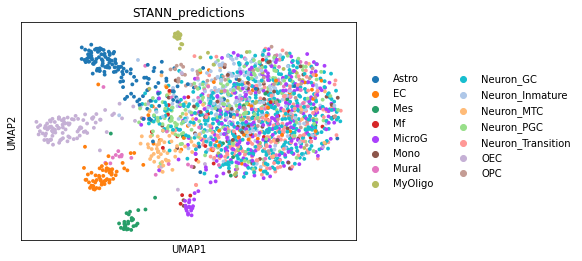

In [32]:
sc.pl.umap(adata_predict,color='STANN_predictions')

## Calculate discrepancy

In [34]:
old_predictions = pd.read_csv("../../output/predictions_updated.csv",index_col="barcode")
old_predictions

,cell_type,X,Y,n_counts,log_counts,n_genes,mt_frac,leiden,cell_type_markers,prediction,FOV
barcode,,,,,,,,,,,
0a,cell_10,1766.40,283.42,1148.0,7.045776,717,0.0,10,Astro,Astro,0
1a,cell_3,1891.40,348.38,841.0,6.734591,555,0.0,1,Neuron_GC1,Neuron_GC,0
2a,cell_1,1548.70,351.11,1704.0,7.440734,1066,0.0,0,Neuron_GC,Neuron_GC,0
3a,cell_15,1657.60,357.37,1439.0,7.271704,940,0.0,9,Neuron_GC2,Neuron_Transition,0
4a,cell_5,1767.40,392.22,1657.0,7.412764,1060,0.0,16,Neuron_Transition,Neuron_GC,0
...,...,...,...,...,...,...,...,...,...,...,...
2045a,cell_9,339.97,1532.30,853.0,6.748760,539,0.0,11,OEC1,OEC,6
2046a,cell_9,608.31,1544.70,735.0,6.599871,463,0.0,11,OEC1,OEC,6
2047a,cell_9,779.11,1551.90,822.0,6.711740,543,0.0,11,OEC1,OEC,6


In [35]:
adata_predict.obs['STANN_predictions_old'] = old_predictions.prediction

In [36]:
results = pd.DataFrame({"old":old_predictions.prediction,"new":predictions.STANN_predictions})

In [37]:
results['diff'] = None

for index, row in results.iterrows():
    if row.old == row.new:
        results.at[index,'diff'] = True
    else:
        results.at[index,'diff'] = False

In [38]:
results['diff'].value_counts()

True     1062
False     988
Name: diff, dtype: int64

/opt/miniconda3/envs/STANN/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'STANN_predictions_old' as categorical


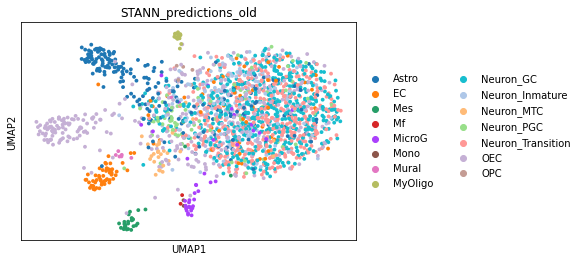

In [39]:
sc.pl.umap(adata_predict,color='STANN_predictions_old')

# Doing train-test split before 

In [40]:
x_train, x_test, y_train, y_test = utils.get_train_test_split(X_train.to_numpy(),
                                                    Y_train_ohe,
                                                    test_size=0.10, 
                                                    random_state=40)

[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


In [59]:
np.argmax(y_train,axis=1).

array([12,  0, 13, ..., 13,  0, 13])

In [61]:
np.unique(np.argmax(y_train,axis=1), return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 array([1091,  907,  120,  112, 1009,  111,  240,  239, 2033,  849,  149,
         287,  532, 2723,  113]))

In [62]:
np.unique(np.argmax(y_test,axis=1), return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 array([133, 114,  14,  11,  92,  11,  16,  38, 234,  72,  20,  36,  58,
        302,  18]))

In [41]:
class_weights = utils.get_class_weights(Y_train_ohe=y_train)
class_weights = {i : class_weights[i] for i in range(15)}
class_weights

/opt/miniconda3/envs/STANN/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14], y=[12  0 13 ... 13  0 13] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 0.6425297891842346,
 1: 0.772877618522602,
 2: 5.841666666666667,
 3: 6.258928571428571,
 4: 0.6947472745292369,
 5: 6.315315315315315,
 6: 2.9208333333333334,
 7: 2.933054393305439,
 8: 0.34481062469257256,
 9: 0.8256772673733804,
 10: 4.704697986577181,
 11: 2.442508710801394,
 12: 1.3176691729323309,
 13: 0.2574366507528461,
 14: 6.20353982300885}

In [42]:
bspca2 = BaseSupervisedPCA(model=LogisticRegression(multi_class="multinomial",
                                                  class_weight=class_weights,
                                                  solver='lbfgs'),
                          n_components=150)
bspca2

In [43]:
%%time

bspca2.fit(x_train,np.argmax(y_train, axis=1))

CPU times: user 1h 6min 35s, sys: 20 s, total: 1h 6min 55s
Wall time: 16min 43s


/opt/miniconda3/envs/STANN/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [44]:
x_train_transformed = bspca.get_transformed_data(x_train)
x_train_transformed

array([[  0.99557745,  33.385796  ,  38.916565  , ...,   1.3616405 ,
          0.18349439,   3.8186593 ],
       [ -7.7136397 ,  -4.201386  ,   1.1833134 , ...,   0.14245908,
         -0.88993794,   0.3463166 ],
       [ -3.1016326 ,  -7.2001576 ,   1.1310573 , ...,  -1.4925796 ,
         -1.4844457 ,  -1.3711841 ],
       ...,
       [ -8.205111  ,  -5.674399  ,   1.0098813 , ...,   1.2550896 ,
          0.78966606,   0.4123404 ],
       [ -5.5456276 ,   0.157697  ,   3.2835453 , ...,   1.503122  ,
          1.7931534 ,  -2.8519888 ],
       [ -9.557248  , -10.379295  ,  -2.0842538 , ...,  -0.70266974,
         -0.4694238 ,   0.6828241 ]], dtype=float32)

In [47]:
model = STANN(act_fun='tanh',
              first_dense=160,
              second_dense=145.0,
              learning_rate=0.01,input_dim=x_train_transformed.shape[1],
              output_dim=len(adata_train.obs.celltype.unique()))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 160)               24160     
_________________________________________________________________
dense_7 (Dense)              (None, 145)               23345     
_________________________________________________________________
dense_8 (Dense)              (None, 15)                2190      
Total params: 49,695
Trainable params: 49,695
Non-trainable params: 0
_________________________________________________________________


In [48]:
history = model.fit(x_train_transformed, 
                    y_train, 
                    validation_split=0.10,
                    epochs=30,
                    class_weight=class_weights,
                    callbacks=[es])

Epoch 1/30
296/296 [==============================] - 0s 1ms/step - loss: 1.1394 - accuracy: 0.6525 - val_loss: 0.7180 - val_accuracy: 0.8356
Epoch 2/30
296/296 [==============================] - 0s 1ms/step - loss: 0.4744 - accuracy: 0.8562 - val_loss: 0.4939 - val_accuracy: 0.8679
Epoch 3/30
296/296 [==============================] - 0s 1ms/step - loss: 0.3376 - accuracy: 0.8875 - val_loss: 0.3823 - val_accuracy: 0.9040
Epoch 4/30
296/296 [==============================] - 0s 1ms/step - loss: 0.2668 - accuracy: 0.9103 - val_loss: 0.3333 - val_accuracy: 0.9059
Epoch 5/30
296/296 [==============================] - 0s 1ms/step - loss: 0.2230 - accuracy: 0.9219 - val_loss: 0.2953 - val_accuracy: 0.9221
Epoch 6/30
296/296 [==============================] - 0s 1ms/step - loss: 0.1914 - accuracy: 0.9343 - val_loss: 0.2642 - val_accuracy: 0.9306
Epoch 7/30
296/296 [==============================] - 0s 1ms/step - loss: 0.1685 - accuracy: 0.9415 - val_loss: 0.2447 - val_accuracy: 0.9306
Epoch 

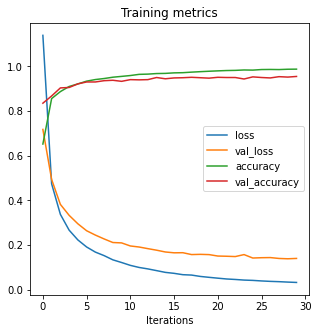

In [49]:
fig, axs = plt.subplots(figsize=(5,5))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training metrics')
plt.xlabel('Iterations')
plt.legend()

In [53]:
x_test_transformed = bspca2.get_transformed_data(np.array(x_test))

In [54]:
utils.print_metrics(model=model,
                  x_train=x_train_transformed,
                  y_train=y_train,
                  x_test=x_test_transformed,
                  y_test=y_test)

[INFO] Accuracy -- Train: 0.985, Test: 0.695
[INFO] ROC -- Train: 1.000, Test: 0.849


/opt/miniconda3/envs/STANN/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'STANN_predictions' as categorical


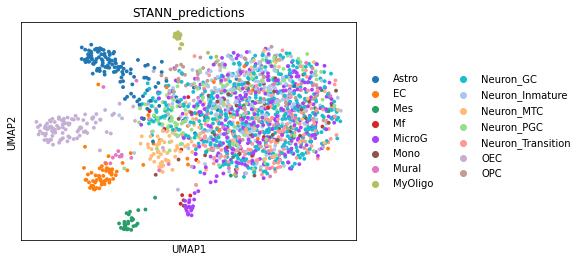

... storing 'STANN_predictions_old' as categorical


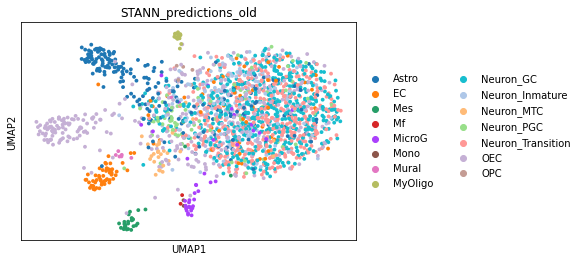

In [55]:
X_predict_transformed = bspca.get_transformed_data(X_predict)
X_predict_transformed.shape

X_predict_transformed = bspca.get_transformed_data(X_predict)

X_predict_transformed.shape

predictions = utils.make_predictions(model=model,

                    X_predict=X_predict_transformed,

                    encoder=encoder,

                    adata_predict=adata_predict,

                    probabilities=False,

                    save=False

                   )


adata_predict.obs['STANN_predictions'] = predictions.STANN_predictions

sc.pl.umap(adata_predict,color='STANN_predictions')


#### Calculate discrepancy - old_predictions

old_predictions = pd.read_csv("../../output/predictions_updated.csv",index_col="barcode")


adata_predict.obs['STANN_predictions_old'] = old_predictions.prediction
results = pd.DataFrame({"old":old_predictions.prediction,"new":predictions.STANN_predictions})
results['diff'] = None

for index, row in results.iterrows():
    if row.old == row.new:
        results.at[index,'diff'] = True
    else:
        results.at[index,'diff'] = False

results['diff'].value_counts()

sc.pl.umap(adata_predict,color='STANN_predictions_old')

# Modified model with sPCA feature selection with accuracy

In [12]:
class BaseSupervisedPCA(object):
    """
    Supervised PCA algorithm proposed by Bair et al. (2006).
    
    
    Parameters
    ----------
    
    fit_intercept : boolean, optional
        whether to calculate the intercept for this model. If set
        to false, no intercept will be used in calculations
        (e.g. data is expected to be already centered).
        
    model : The supervised learning model that will be used to conduct supervised PCA.
    
    Attributes
    ----------
        
    
    References
    ----------
    Bair, Eric, et al. "Prediction by supervised principal components." Journal of the American Statistical Association 101.473 (2006).
    
    """
    
    def __init__(self, 
                 fit_intercept=True, 
                 model=None,
                 threshold=0.5,
                 n_components=-1):
        
        
        self.fit_intercept = fit_intercept
        self._model=model
        self._pca=None
        self._leavouts=None
        self._scores=None
        self._scores_balanced=None
        
        self._threshold=threshold
        self._n_components=n_components
    
    
    def rank_features(self,X,y,weights):
        
        #these are the columns that will be removed
        self._leavouts=[]        
        self._scores=[] 
        self._scores_balanced=[]
        
        dummy_X=X[:,np.newaxis]
        
        #test the absolute value of the coefficient for each variable. If it
        #is below a the threshold, then add it to the leaveouts 
        
        
        print('[INFO] Running feature selection')
        
        for i in tqdm.tqdm(range(0,dummy_X.shape[2]),total=dummy_X.shape[2]):
            
            current_X=dummy_X[:,:,i]
            self._model.fit(current_X, y)
            #the all([]) syntax is there in order to support both linear and logistic
            #regression. Logistic regression coefficients for multiclass problems
            #come in multi-dimensional arrays.
            #print(self._model.coef_)
            
            self._model.predict(current_X)
            
            #print(current_X.shape)
            score_balanced = sklearn.metrics.balanced_accuracy_score(y, 
                                                    self._model.predict(current_X),
                                                    #sample_weight=weights, 
                                                    adjusted=False)
            
            score_not_balanced = sklearn.metrics.accuracy_score(y, self._model.predict(current_X))
            
            self._scores.append(score_not_balanced)
            self._scores_balanced.append(score_balanced)
        
        
        return self._scores, self._scores_balanced
    
    def subset_features(self,
                        X,
                        _scores,
                        top=5000):
        
        
        _scores_pd = pd.DataFrame({'index_position':np.arange(0,X.shape[1]),
              '_scores_balanced': _scores})
        
        _leaveouts = list(_scores_pd.sort_values(by='_scores_balanced',ascending=True)[:X.shape[1]-top].index_position)
        
        
        dummy_X=X[:,np.newaxis]
        #delete the variables that were below the threshold
        if(len(_leaveouts)>0):
            
            dummy_X=np.delete(dummy_X,_leaveouts,2)
            
        
            
        if(len(_leaveouts)==dummy_X.shape[2]):
            raise ValueError('The total number of features to be left out is equal to the total number of features. Please try with a smaller threshold value.')
            
        
        return dummy_X
        

        
    #def subset_feature(self,X,y,)
    #
    #    #delete the variables that were below the threshold
    #    if(len(self._leavouts)>0):
    #        dummy_X=np.delete(dummy_X,self._leavouts,2)
    #    
    #    return 
    
    def fit(self,X,y):
        """
        Fit the supervised PCA model
        .
        Parameters
        ----------
        X : numpy array or sparse matrix of shape [n_samples,n_features]
            Training data
        y : numpy array of shape [n_samples, n_targets]
            Target values
        threshold : the threshold for the coefficient below which it is discarded.
        n_components : the number of components to keep, after running PCA
        
        Returns
        -------
        self : returns an instance of self.
        """
        
        
        #conduct PCA for the designated number of components.
        #If no number was designated (or an illegal value<=0) then use the max number of component
        
        if(self._n_components>0):
            self._pca = PCA(n_components=self._n_components)
        else:
            self._pca = PCA(n_components=X.shape[2])
            
        dummy_X=self._pca.fit_transform(X[:,0,:])
        
        self._model=self._model.fit(dummy_X,y)
        
        
        return self
        
    def predict(self,X):
        """Predict using the supervised PCA model
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = (n_samples, n_features)
            Samples.
        Returns
        -------
        C : array, shape = (n_samples,)
            Returns predicted values.        
        """
        #remove the leavouts, transform the data and fit the regression model
        transformed_X=self.get_transformed_data(X)
        return self._model.predict(transformed_X)
    
    def get_transformed_data(self,X):
        """Calculates the components on a new matrix.
        Parameters
        ----------
        X : numpy array or sparse matrix of shape [n_samples,n_features]
            
        Returns
        -------
        transformed_X: Returns a transformed numpy array or sparse matrix. The
        leavouts have been removed and the remaining variables are transformed into
        components using the weights of the PCA object.
        
        Notes
        -------
        The algorithm should have first been executed on a dataset.
        
        """
        #transformed_X=np.delete(X,self._leavouts,1)
        
        transformed_X = X[:,0,:]
        transformed_X=self._pca.transform(transformed_X)
        
        return transformed_X
        
    def get_n_components(self):
        return self._pca.n_components_
    
    
    #I am implementing a function here to get the components in order to avoid
    #the user having to access the pca object. Another option would be to 
    #copy the components from the pca to a variable located at 'self'. However,
    #this might be too redundant.
    
    def get_components(self):
        """Returns the components formerly calculated on a training dataset.
            
        Returns
        -------
        components: A numpy matrix with the loadings of the PCA components.
        
        Notes
        -------
        The algorithm should have first been executed on a dataset.
        
        """
        return self._pca.components_
    
    #same principle as in the get_components function
    def get_coefs(self):
        return self._model.coef_
        
    def score(self,X,y):
        return self._model.score(X,y)
    
        

class SupervisedPCAClassifier(BaseSupervisedPCA,ClassifierMixin):
    """Implementation of supervisedPCA for classification. The underlying model
    is a logistic regression model.
    Parameters
    ----------
    penalty : str, 'l1' or 'l2'
        Used to specify the norm used in the penalization. The newton-cg and
        lbfgs solvers support only l2 penalties.
    dual : bool
        Dual or primal formulation. Dual formulation is only implemented for
        l2 penalty with liblinear solver. Prefer dual=False when
        n_samples > n_features.
    C : float, optional (default=1.0)
        Inverse of regularization strength; must be a positive float.
        Like in support vector machines, smaller values specify stronger
        regularization.
    fit_intercept : bool, default: True
        Specifies if a constant (a.k.a. bias or intercept) should be
        added the decision function.
    intercept_scaling : float, default: 1
        Useful only if solver is liblinear.
        when self.fit_intercept is True, instance vector x becomes
        [x, self.intercept_scaling],
        i.e. a "synthetic" feature with constant value equals to
        intercept_scaling is appended to the instance vector.
        The intercept becomes intercept_scaling * synthetic feature weight
        Note! the synthetic feature weight is subject to l1/l2 regularization
        as all other features.
        To lessen the effect of regularization on synthetic feature weight
        (and therefore on the intercept) intercept_scaling has to be increased.
    class_weight : dict or 'balanced', optional
        Weights associated with classes in the form ``{class_label: weight}``.
        If not given, all classes are supposed to have weight one.
        The "balanced" mode uses the values of y to automatically adjust
        weights inversely proportional to class frequencies in the input data
        as ``n_samples / (n_classes * np.bincount(y))``
    max_iter : int
        Useful only for the newton-cg and lbfgs solvers. Maximum number of
        iterations taken for the solvers to converge.
    random_state : int seed, RandomState instance, or None (default)
        The seed of the pseudo random number generator to use when
        shuffling the data.
    solver : {'newton-cg', 'lbfgs', 'liblinear'}
        Algorithm to use in the optimization problem.
    tol : float, optional
        Tolerance for stopping criteria.
    multi_class : str, {'ovr', 'multinomial'}
        Multiclass option can be either 'ovr' or 'multinomial'. If the option
        chosen is 'ovr', then a binary problem is fit for each label. Else
        the loss minimised is the multinomial loss fit across
        the entire probability distribution. Works only for the 'lbfgs'
        solver.
    verbose : int
        For the liblinear and lbfgs solvers set verbose to any positive
        number for verbosity.
    """
    def __init__(self,fit_intercept=True, normalize=False, copy_X=True,penalty='l2', dual=False, tol=1e-4, C=1.0,
                 intercept_scaling=1, class_weight=None,
                 random_state=None, solver='liblinear', max_iter=100,
                 multi_class='ovr', verbose=0,threshold=0,n_components=-1):
        model=LogisticRegression()  
        super(SupervisedPCAClassifier,self).__init__(fit_intercept=fit_intercept,model=model,threshold=threshold,n_components=n_components)
    
    def predict_proba(self,X):
        return self._model.predict_proba(X)

In [14]:
class_weights = utils.get_class_weights(Y_train_ohe=Y_train_ohe)
class_weights = {i : class_weights[i] for i in range(15)}
class_weights

/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14], y=[13  0  8 ...  8 13 13] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


{0: 0.6363834422657952,
 1: 0.7629121776036566,
 2: 5.812935323383084,
 3: 6.332791327913279,
 4: 0.7074780502573418,
 5: 6.384699453551913,
 6: 3.042708333333333,
 7: 2.8120336943441635,
 8: 0.3435965299220703,
 9: 0.8457473760405356,
 10: 4.609072978303748,
 11: 2.41155830753354,
 12: 1.320225988700565,
 13: 0.25749862258953166,
 14: 5.9460559796437655}

In [169]:
bspca = BaseSupervisedPCA(model=LogisticRegression(multi_class="multinomial",
                                                  class_weight=class_weights,
                                                  solver='lbfgs'),
                                                  n_components=200)
bspca

In [38]:
%%time

_scores,_scores_balanced = bspca.rank_features(np.array(X_train),
                                                             Y_train_dummy,
                                                             class_weights)

  0%|          | 1/9031 [00:00<20:50,  7.22it/s]

[INFO] Running feature selection


100%|██████████| 9031/9031 [19:54<00:00,  7.56it/s]

CPU times: user 1h 30min 53s, sys: 20min 52s, total: 1h 51min 46s
Wall time: 19min 54s


In [29]:
_scores_balanced_pd = pd.DataFrame({'index_position':np.arange(0,np.array(X_train).shape[1]),
              '_scores': _scores_balanced})

_scores_pd = pd.DataFrame({'index_position':np.arange(0,np.array(X_train).shape[1]),
              '_scores': _scores})

NameError: name '_scores_balanced' is not defined

In [58]:
_scores_balanced_pd.to_csv('./features_scores_balanced.csv')
_scores_pd.to_csv('./features_scores.csv')

In [ ]:
# Read feature scores back 

In [13]:
_scores_balanced_pd = pd.read_csv('./features_scores_balanced.csv',index_col='Unnamed: 0')
_scores_pd = pd.read_csv('./features_scores.csv',index_col='Unnamed: 0')

In [14]:
_scores = np.array(_scores_pd['_scores_balanced'])
_scores_balanced = np.array(_scores_pd['_scores_balanced'])

In [45]:
bspca_results_diff_features = pd.DataFrame()

for top in [9030,5000,4000,3000]:
    
    bspca = None
    
    bspca = BaseSupervisedPCA(model=LogisticRegression(multi_class="multinomial",
                                                  class_weight=class_weights,
                                                  solver='lbfgs'),
                                                  n_components=200)
    
    X = bspca.subset_features(np.array(X_train),
                     _scores_balanced,
                     top)
    
    
    #print(X.shape)
    
    bspca.fit(X,Y_train_dummy)
    
    X_train_transformed = bspca.get_transformed_data(X)
    
    x_train, x_test, y_train, y_test = utils.get_train_test_split(X_train_transformed,
                                                    Y_train_ohe,
                                                    test_size=0.10, 
                                                    random_state=40)
    model = STANN(act_fun='tanh',
              first_dense=160,
              second_dense=145.0,
              learning_rate=0.01,input_dim=X_train_transformed.shape[1],
              output_dim=len(adata_train.obs.celltype.unique()))
    
    #early stopping
    es = tf.keras.callbacks.EarlyStopping(monitor='accuracy', 
                                      mode='min', 
                                      verbose=1,
                                      patience=30)
    
    history = model.fit(x_train, 
                    y_train, 
                    validation_split=0.10,
                    epochs=30,
                    class_weight=class_weights,
                    callbacks=[es],
                    verbose=0)
    
    #fig, axs = plt.subplots(figsize=(5,5))
    #plt.plot(history.history['loss'], label='loss')
    #plt.plot(history.history['val_loss'], label='val_loss')
    #plt.plot(history.history['accuracy'], label='accuracy')
    #plt.plot(history.history['val_accuracy'], label='val_accuracy')
    #plt.title('Training metrics')
    #plt.xlabel('Iterations')
    #plt.legend()
    
    train_acc, test_acc, train_roc, test_roc = utils.get_metrics(model=model,
                  x_train=x_train,
                  y_train=y_train,
                  x_test=x_test,
                  y_test=y_test)
    
    bspca_results_diff_features = bspca_results_diff_features.append({'Model':"STANN sPCA",
                                                                      'Train-Test split':"Before",
                                                                      'No PCs':200,
                                                                     'No Features': top,
                                                                     'Train acc':train_acc,
                                                                     'Test acc':test_acc,
                                                                     'Train roc':train_roc,
                                                                     'Test roc':test_roc},
                                                                    ignore_index=True)

/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[INFO] X_train shape=(10515, 200)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 200)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[INFO] X_train shape=(10515, 200)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 200)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[INFO] X_train shape=(10515, 200)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 200)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[INFO] X_train shape=(10515, 200)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 200)
[INFO] y_test shape=(1169, 15)


In [46]:
for top in [9030,5000,4000,3000]:
    
    x_train, x_test, y_train, y_test = utils.get_train_test_split(X_train.to_numpy(),
                                                    Y_train_ohe,
                                                    test_size=0.10, 
                                                    random_state=40)
    
    bspca = None
    
    bspca = BaseSupervisedPCA(model=LogisticRegression(multi_class="multinomial",
                                                  class_weight=class_weights,
                                                  solver='lbfgs'),
                                                  n_components=200)
    
    X = bspca.subset_features(x_train,
                     _scores_balanced,
                     top)
    
    #print(X.shape)
    bspca.fit(X,np.argmax(y_train, axis=1))
    
    x_train_transformed = bspca.get_transformed_data(X)
    

    model = STANN(act_fun='tanh',
              first_dense=160,
              second_dense=145.0,
              learning_rate=0.01,input_dim=x_train_transformed.shape[1],
              output_dim=len(adata_train.obs.celltype.unique()))
    
    #early stopping
    es = tf.keras.callbacks.EarlyStopping(monitor='accuracy', 
                                      mode='min', 
                                      verbose=1,
                                      patience=30)
    
    history = model.fit(x_train_transformed, 
                    y_train, 
                    validation_split=0.10,
                    epochs=30,
                    class_weight=class_weights,
                    callbacks=[es],
                    verbose=0)
    
    #fig, axs = plt.subplots(figsize=(5,5))
    #plt.plot(history.history['loss'], label='loss')
    #plt.plot(history.history['val_loss'], label='val_loss')
    #plt.plot(history.history['accuracy'], label='accuracy')
    #plt.plot(history.history['val_accuracy'], label='val_accuracy')
    #plt.title('Training metrics')
    #plt.xlabel('Iterations')
    #plt.legend()
    
    x_test_subset = bspca.subset_features(x_test,
                     _scores_balanced,
                     top)
    
    x_test_transformed = bspca.get_transformed_data(x_test_subset)
    
    #utils.print_metrics(model=model,
    #              x_train=x_train_transformed,
    #              y_train=y_train,
    #              x_test=x_test_transformed,
    #              y_test=y_test)
    
    
    train_acc, test_acc, train_roc, test_roc = utils.get_metrics(model=model,
                  x_train=x_train_transformed,
                  y_train=y_train,
                  x_test=x_test_transformed,
                  y_test=y_test)
    
    bspca_results_diff_features = bspca_results_diff_features.append({'Model':"STANN sPCA",
                                                                      'Train-Test split':"After",
                                                                      'No PCs':200,
                                                                     'No Features': top,
                                                                     'Train acc':train_acc,
                                                                     'Test acc':test_acc,
                                                                     'Train roc':train_roc,
                                                                     'Test roc':test_roc},
                                                                    ignore_index=True)

[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [47]:
top=7000
for n_comps in [200,500,1000,1250,1500,2000,3000,5000]:
    
    x_train, x_test, y_train, y_test = utils.get_train_test_split(X_train.to_numpy(),
                                                    Y_train_ohe,
                                                    test_size=0.10, 
                                                    random_state=40)
    
    bspca = None
    
    bspca = BaseSupervisedPCA(model=LogisticRegression(multi_class="multinomial",
                                                  class_weight=class_weights,
                                                  solver='lbfgs'),
                                                  n_components=n_comps)
    
    X = bspca.subset_features(x_train,
                     _scores_balanced,
                     top)
    
    #print(X.shape)
    bspca.fit(X,np.argmax(y_train, axis=1))
    
    x_train_transformed = bspca.get_transformed_data(X)
    

    model = STANN(act_fun='tanh',
              first_dense=160,
              second_dense=145.0,
              learning_rate=0.01,input_dim=x_train_transformed.shape[1],
              output_dim=len(adata_train.obs.celltype.unique()))
    
    #early stopping
    es = tf.keras.callbacks.EarlyStopping(monitor='accuracy', 
                                      mode='min', 
                                      verbose=1,
                                      patience=30)
    
    history = model.fit(x_train_transformed, 
                    y_train, 
                    validation_split=0.10,
                    epochs=30,
                    class_weight=class_weights,
                    callbacks=[es],
                    verbose=0)
    
    #fig, axs = plt.subplots(figsize=(5,5))
    #plt.plot(history.history['loss'], label='loss')
    #plt.plot(history.history['val_loss'], label='val_loss')
    #plt.plot(history.history['accuracy'], label='accuracy')
    #plt.plot(history.history['val_accuracy'], label='val_accuracy')
    #plt.title('Training metrics')
    #plt.xlabel('Iterations')
    #plt.legend()
    
    x_test_subset = bspca.subset_features(x_test,
                     _scores_balanced,
                     top)
    
    x_test_transformed = bspca.get_transformed_data(x_test_subset)
    
    #utils.print_metrics(model=model,
    #              x_train=x_train_transformed,
    #              y_train=y_train,
    #              x_test=x_test_transformed,
    #              y_test=y_test)
    
    
    train_acc, test_acc, train_roc, test_roc = utils.get_metrics(model=model,
                  x_train=x_train_transformed,
                  y_train=y_train,
                  x_test=x_test_transformed,
                  y_test=y_test)
    
    bspca_results_diff_features = bspca_results_diff_features.append({'Model':"STANN sPCA",
                                                                      'Train-Test split':"After",
                                                                      'No PCs':n_comps,
                                                                     'No Features': top,
                                                                     'Train acc':train_acc,
                                                                     'Test acc':test_acc,
                                                                     'Train roc':train_roc,
                                                                     'Test roc':test_roc},
                                                                    ignore_index=True)

[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [48]:
bspca_results_diff_features

,Model,No Features,No PCs,Test acc,Test roc,Train acc,Train roc,Train-Test split
0,STANN sPCA,9030.0,200.0,0.940120,0.996549,0.988017,0.999810,Before
1,STANN sPCA,5000.0,200.0,0.946963,0.997484,0.986971,0.999815,Before
2,STANN sPCA,4000.0,200.0,0.935843,0.996335,0.985449,0.999752,Before
3,STANN sPCA,3000.0,200.0,0.936698,0.995418,0.978031,0.999629,Before
4,STANN sPCA,9030.0,200.0,0.949530,0.997937,0.989349,0.999817,After
5,STANN sPCA,5000.0,200.0,0.950385,0.997060,0.984213,0.999778,After
6,STANN sPCA,4000.0,200.0,0.942686,0.997433,0.983167,0.999723,After
7,STANN sPCA,3000.0,200.0,0.949530,0.996057,0.982216,0.999639,After
8,STANN sPCA,7000.0,200.0,0.952096,0.996607,0.987161,0.999839,After
9,STANN sPCA,7000.0,500.0,0.952951,0.996842,0.994104,0.999908,After


In [49]:
bspca_results_diff_features.to_csv('../outputs/hyper-parameter-search.csv')

# Final model - Cross-validation

In [15]:
# Nofeatures 8000
# No PCs 5000


cv_results = pd.DataFrame()

top=8000
pcs=5000

for fold in range(10):
    
    x_train, x_test, y_train, y_test = utils.get_train_test_split(X_train.to_numpy(),
                                                    Y_train_ohe,
                                                    test_size=0.20, 
                                                    random_state=np.random.randint(1,1000, 1)[0])
    
    bspca = None
    
    bspca = BaseSupervisedPCA(model=LogisticRegression(multi_class="multinomial",
                                                  class_weight=class_weights,
                                                  solver='lbfgs'),
                                                  n_components=pcs)
    
    X = bspca.subset_features(x_train,
                     _scores_balanced,
                     top)
    
    #print(X.shape)
    bspca.fit(X,np.argmax(y_train, axis=1))
    
    x_train_transformed = bspca.get_transformed_data(X)
    

    model = STANN(act_fun='tanh',
              first_dense=160,
              second_dense=145.0,
              learning_rate=0.01,input_dim=x_train_transformed.shape[1],
              output_dim=len(adata_train.obs.celltype.unique()))
    
    #early stopping
    es = tf.keras.callbacks.EarlyStopping(monitor='accuracy', 
                                      mode='min', 
                                      verbose=1,
                                      patience=35)
    
    history = model.fit(x_train_transformed, 
                    y_train, 
                    validation_split=0.10,
                    epochs=30,
                    class_weight=class_weights,
                    callbacks=[es],
                    verbose=0)
    
    #fig, axs = plt.subplots(figsize=(5,5))
    #plt.plot(history.history['loss'], label='loss')
    #plt.plot(history.history['val_loss'], label='val_loss')
    #plt.plot(history.history['accuracy'], label='accuracy')
    #plt.plot(history.history['val_accuracy'], label='val_accuracy')
    #plt.title('Training metrics')
    #plt.xlabel('Iterations')
    #plt.legend()
    
    x_test_subset = bspca.subset_features(x_test,
                     _scores_balanced,
                     top)
    
    x_test_transformed = bspca.get_transformed_data(x_test_subset)
    
    #utils.print_metrics(model=model,
    #              x_train=x_train_transformed,
    #              y_train=y_train,
    #              x_test=x_test_transformed,
    #              y_test=y_test)
    
    
    train_acc, test_acc, train_roc, test_roc = utils.get_metrics(model=model,
                  x_train=x_train_transformed,
                  y_train=y_train,
                  x_test=x_test_transformed,
                  y_test=y_test)
    
    cv_results = cv_results.append({'Split':fold,
                                                                     'Train acc':train_acc,
                                                                     'Test acc':test_acc,
                                                                     'Train roc':train_roc,
                                                                     'Test roc':test_roc},
                                                                    ignore_index=True)

[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/opt/miniconda3/envs/STANN/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/opt/miniconda3/envs/STANN/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/opt/miniconda3/envs/STANN/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/opt/miniconda3/envs/STANN/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/opt/miniconda3/envs/STANN/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/opt/miniconda3/envs/STANN/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/opt/miniconda3/envs/STANN/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/opt/miniconda3/envs/STANN/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/opt/miniconda3/envs/STANN/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/opt/miniconda3/envs/STANN/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [16]:
cv_results

,Split,Test acc,Test roc,Train acc,Train roc
0,0.0,0.952096,0.997125,0.995340,0.999958
1,1.0,0.956373,0.998313,0.995530,0.999967
2,2.0,0.954662,0.997927,0.995911,0.999965
3,3.0,0.949530,0.998275,0.995150,0.999967
4,4.0,0.957228,0.997907,0.995530,0.999933
5,5.0,0.954662,0.997670,0.996291,0.999955
6,6.0,0.946963,0.997370,0.995055,0.999966
7,7.0,0.949530,0.997623,0.995530,0.999970
8,8.0,0.951240,0.997622,0.995720,0.999940
9,9.0,0.951240,0.997663,0.994579,0.999945


In [17]:
train_acc = np.mean(cv_results['Train acc'])*100
train_acc_std = np.std(cv_results['Train acc'])*100

In [18]:
print(f'10 fold train acc is = {train_acc:.3f} +- {train_acc_std:.3f}')

10 fold train acc is = 99.546 +- 0.045


In [19]:
test_acc = np.mean(cv_results['Test acc'])*100
test_acc_std = np.std(cv_results['Test acc'])*100

In [20]:
print(f'10 fold train acc is = {test_acc:.3f} +- {test_acc_std:.3f}')

10 fold train acc is = 95.235 +- 0.313


# Final model predictions

[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/opt/miniconda3/envs/STANN/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Epoch 1/30
329/329 [==============================] - 1s 3ms/step - loss: 0.9617 - accuracy: 0.6908 - val_loss: 0.5039 - val_accuracy: 0.8828
Epoch 2/30
329/329 [==============================] - 1s 2ms/step - loss: 0.2388 - accuracy: 0.9311 - val_loss: 0.2986 - val_accuracy: 0.9316
Epoch 3/30
329/329 [==============================] - 1s 2ms/step - loss: 0.1259 - accuracy: 0.9668 - val_loss: 0.2278 - val_accuracy: 0.9401
Epoch 4/30
329/329 [==============================] - 1s 2ms/step - loss: 0.0755 - accuracy: 0.9827 - val_loss: 0.2140 - val_accuracy: 0.9358
Epoch 5/30
329/329 [==============================] - 1s 2ms/step - loss: 0.0534 - accuracy: 0.9896 - val_loss: 0.1848 - val_accuracy: 0.9487
Epoch 6/30
329/329 [==============================] - 1s 2ms/step - loss: 0.0370 - accuracy: 0.9943 - val_loss: 0.1712 - val_accuracy: 0.9512
Epoch 7/30
329/329 [==============================] - 1s 2ms/step - loss: 0.0279 - accuracy: 0.9965 - val_loss: 0.1665 - val_accuracy: 0.9504
Epoch 

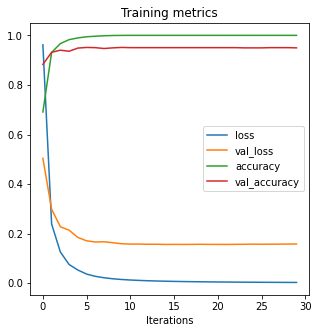

In [21]:
top=8000
pcs=5000


    
x_train, x_test, y_train, y_test = utils.get_train_test_split(X_train.to_numpy(),
                                                Y_train_ohe,
                                                test_size=0.10, 
                                                random_state=123)

bspca = None

bspca = BaseSupervisedPCA(model=LogisticRegression(multi_class="multinomial",
                                              class_weight=class_weights,
                                              solver='lbfgs'),
                                              n_components=pcs)

X = bspca.subset_features(x_train,
                 _scores_balanced,
                 top)

#print(X.shape)
bspca.fit(X,np.argmax(y_train, axis=1))

x_train_transformed = bspca.get_transformed_data(X)


model = STANN(act_fun='tanh',
          first_dense=160,
          second_dense=145.0,
          learning_rate=0.01,input_dim=x_train_transformed.shape[1],
          output_dim=len(adata_train.obs.celltype.unique()))

#early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='accuracy', 
                                  mode='min', 
                                  verbose=1,
                                  patience=30)

x_test_subset = bspca.subset_features(x_test,
                 _scores_balanced,
                 top)

x_test_transformed = bspca.get_transformed_data(x_test_subset)


history = model.fit(x_train_transformed, 
                y_train, 
                validation_data=(x_test_transformed,y_test),
                epochs=30,
                class_weight=class_weights,
                callbacks=[es],
                verbose=1)

fig, axs = plt.subplots(figsize=(5,5))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training metrics')
plt.xlabel('Iterations')
plt.legend()

In [22]:
utils.print_metrics(model=model,
              x_train=x_train_transformed,
              y_train=y_train,
              x_test=x_test_transformed,
              y_test=y_test)

[INFO] Accuracy -- Train: 1.000, Test: 0.950
[INFO] ROC -- Train: 1.000, Test: 0.997


In [23]:
X_predict_subset = bspca.subset_features(X_predict.to_numpy(),
                 _scores_balanced,
                 top)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


/opt/miniconda3/envs/STANN/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'STANN_predictions' as categorical


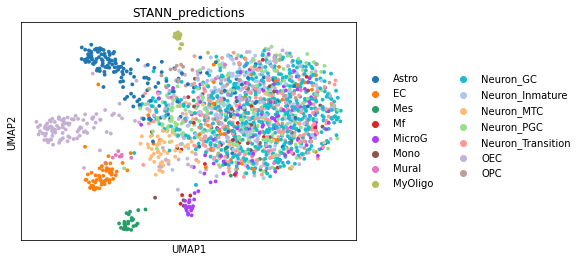

... storing 'STANN_predictions_old' as categorical


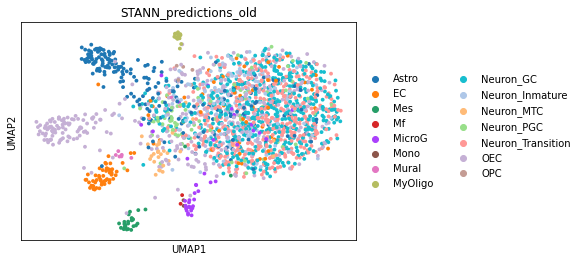

In [24]:
X_predict_subset = bspca.subset_features(X_predict.to_numpy(),
                 _scores_balanced,
                 top)


X_predict_transformed = bspca.get_transformed_data(X_predict_subset)
X_predict_transformed.shape

predictions = utils.make_predictions(model=model,

                    X_predict=X_predict_transformed,

                    encoder=encoder,

                    adata_predict=adata_predict,

                    probabilities=False,

                    save=False

                   )


adata_predict.obs['STANN_predictions'] = predictions.STANN_predictions

sc.pl.umap(adata_predict,color='STANN_predictions')


#### Calculate discrepancy - old_predictions

old_predictions = pd.read_csv("../../output/predictions_updated.csv",index_col="barcode")


adata_predict.obs['STANN_predictions_old'] = old_predictions.prediction
results = pd.DataFrame({"old":old_predictions.prediction,"new":predictions.STANN_predictions})
results['diff'] = None

for index, row in results.iterrows():
    if row.old == row.new:
        results.at[index,'diff'] = True
    else:
        results.at[index,'diff'] = False

results['diff'].value_counts()

sc.pl.umap(adata_predict,color='STANN_predictions_old')

In [26]:
results['diff'].value_counts()

True     1188
False     862
Name: diff, dtype: int64

In [27]:
adata_predict.obs.to_csv('../../output/predictions_nov2020_v2.csv')

In [ ]:
#CV

In [23]:
def cross_validate(n_folds=10,
                   X_train=None,
                   Y_train_ohe=None,
                   model=None,
                   top=7000,
                   pcs=500,
                   encoder_sc=None):
    """
    returns and print cross valditation scores
    
    parameters-> 
    
    n_folds = 10 (predetermined)
    X= X and y=y (data)
    model = keras model
    
    """
    
    cv_scores, model_history = list(), list()
    
    report_train_all = pd.DataFrame()
    report_test_all = pd.DataFrame()
    
    cm_train_all = {}
    cm_test_all = {}
    
    for fold in range(n_folds):
        
        print(f'For fold = {fold}')
              
        
        
        x_train, x_test, y_train, y_test = utils.get_train_test_split(X_train.to_numpy(),
                                                    Y_train_ohe,
                                                    test_size=0.10, 
                                                    random_state=np.random.randint(1,1000, 1)[0])
    
        bspca = None
    
        bspca = BaseSupervisedPCA(model=LogisticRegression(multi_class="multinomial",
                                                  class_weight=class_weights,
                                                  solver='lbfgs'),
                                                  n_components=pcs)
    
        X = bspca.subset_features(x_train,
                     _scores_balanced,
                     top)
    
        print(X.shape)
        bspca.fit(X,np.argmax(y_train, axis=1))
    
        x_train_transformed = bspca.get_transformed_data(X)
        print(x_train_transformed.shape)

        model = STANN(act_fun='tanh',
              first_dense=160,
              second_dense=145.0,
              learning_rate=0.01,input_dim=x_train_transformed.shape[1],
              output_dim=len(adata_train.obs.celltype.unique()))
    
        #early stopping
        es = tf.keras.callbacks.EarlyStopping(monitor='accuracy', 
                                      mode='min', 
                                      verbose=1,
                                      patience=30)
    
        history = model.fit(x_train_transformed, 
                    y_train, 
                    validation_split=0.10,
                    epochs=30,
                    class_weight=class_weights,
                    callbacks=[es],
                    verbose=0)
    

    
        x_test_subset = bspca.subset_features(x_test,
                     _scores_balanced,
                     top)
    
        x_test_transformed = bspca.get_transformed_data(x_test_subset)
    

        train_acc, test_acc, train_roc, test_roc = utils.get_metrics(model=model,
                  x_train=x_train_transformed,
                  y_train=y_train,
                  x_test=x_test_transformed,
                  y_test=y_test)
    
        
        #get scoring metrics
        _, train_acc = model.evaluate(x_train_transformed, y_train, verbose = 0)
        _, test_acc = model.evaluate(x_test_transformed, y_test, verbose=0)
        

        print(f'>train_acc={train_acc} & test_acc={test_acc}')
        print('')
        
        cv_scores.append([train_acc, test_acc])
        model_history.append(history)
    
    
        y_train_pred_sc =  model.predict(x_train_transformed)
        y_train_pred_sc = np.argmax(y_train_pred_sc, axis=1)
        y_train_pred_sc = encoder_sc.inverse_transform(y_train_pred_sc)
        
        y_train_sc_decoded = np.argmax(y_train, axis=1)
        y_train_sc_decoded = encoder_sc.inverse_transform(y_train_sc_decoded)
        
        y_test_pred_sc =  model.predict(x_test_transformed)
        y_test_pred_sc = np.argmax(y_test_pred_sc, axis=1)
        y_test_pred_sc = encoder_sc.inverse_transform(y_test_pred_sc)
        
        y_test_sc_decoded = np.argmax(y_test, axis=1)
        y_test_sc_decoded = encoder_sc.inverse_transform(y_test_sc_decoded)
        
        
        
        
        report_train = sklearn.metrics.classification_report(y_train_sc_decoded,y_train_pred_sc,output_dict=True)
        report_train = pd.DataFrame(report_train)
        #report_train['test'] = test
        report_train['fold'] = fold
        report_train_all.append(report_train)
        report_train_all = report_train_all.append(report_train,ignore_index=True)
        
        report_test = sklearn.metrics.classification_report(y_test_sc_decoded,y_test_pred_sc,output_dict=True)
        report_test = pd.DataFrame(report_test)
        #report_test['test'] = test
        report_test['fold'] = fold
        report_test_all = report_test_all.append(report_test,ignore_index=True)
        
        
        cm_train_all[f'fold_{fold}'] = [y_train_sc_decoded,y_train_pred_sc,fold]
        cm_test_all[f'fold_{fold}'] =  [y_test_sc_decoded,y_test_pred_sc,fold]       
    
    return cv_scores, model_history, report_test_all, report_train_all, cm_train_all, cm_test_all

In [27]:
cv_scores, model_history, report_test_all, report_train_all, cm_train_all, cm_test_all = cross_validate(n_folds=10,
                                          X_train=X_train,
                                          Y_train_ohe=Y_train_ohe,
                                          top=7000,
                                          pcs=5000,                                                              
                                          encoder_sc = encoder)

report_test_all.to_csv('../../output/report_test_all_CV_nov2020_7000FEATURES_5000PCS.csv')
report_train_all.to_csv('../../output/report_train_all_CV_nov2020_7000FEATURES_5000PCS.csv')
cv_scores_pd = pd.DataFrame(columns= ['train_acc', 'test_acc'], data = cv_scores)
cv_scores_pd.to_csv('../../output/cv_scores_nov2020_7000FEATURES_5000PCS.csv')

For fold = 0
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 7000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 5000)
>train_acc=0.9950546622276306 & test_acc=0.9520958065986633

For fold = 1
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 7000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 5000)
>train_acc=0.9954351186752319 & test_acc=0.9538066983222961

For fold = 2
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 7000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 5000)
>train_acc=0.9953399896621704 & test_acc=0.9418306350708008

For fold = 3
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 7000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 5000)
>train_acc=0.9955301880836487 & test_acc=0.9512403607368469

For fold = 4
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 7000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 5000)
>train_acc=0.9953399896621704 & test_acc=0.9478186368942261

For fold = 5
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 7000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 5000)
>train_acc=0.9954351186752319 & test_acc=0.9512403607368469

For fold = 6
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 7000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 5000)
>train_acc=0.9956253170967102 & test_acc=0.9520958065986633

For fold = 7
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 7000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 5000)
>train_acc=0.9959105849266052 & test_acc=0.9503849148750305

For fold = 8
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 7000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 5000)
>train_acc=0.9953399896621704 & test_acc=0.9529512524604797

For fold = 9
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 7000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 5000)
>train_acc=0.9950546622276306 & test_acc=0.9426860809326172



In [28]:
cv_scores, model_history, report_test_all, report_train_all, cm_train_all, cm_test_all = cross_validate(n_folds=10,
                                          X_train=X_train,
                                          Y_train_ohe=Y_train_ohe,
                                          top=8000,
                                          pcs=6000,                                                              
                                          encoder_sc = encoder)

report_test_all.to_csv('../../output/report_test_all_CV_nov2020_8000FEATURES_6000PCS.csv')
report_train_all.to_csv('../../output/report_train_all_CV_nov2020_8000FEATURES_6000PCS.csv')
cv_scores_pd = pd.DataFrame(columns= ['train_acc', 'test_acc'], data = cv_scores)
cv_scores_pd.to_csv('../../output/cv_scores_nov2020_8000FEATURES_6000PCS.csv')

For fold = 0
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 8000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 6000)
>train_acc=0.9960057139396667 & test_acc=0.9520958065986633

For fold = 1
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 8000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 6000)
>train_acc=0.9959105849266052 & test_acc=0.9512403607368469

For fold = 2
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 8000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 6000)
>train_acc=0.9944840669631958 & test_acc=0.9495295286178589

For fold = 3
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 8000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 6000)
>train_acc=0.9953399896621704 & test_acc=0.9469631910324097

For fold = 4
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 8000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 6000)
>train_acc=0.9956253170967102 & test_acc=0.9512403607368469

For fold = 5
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 8000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 6000)
>train_acc=0.9953399896621704 & test_acc=0.9503849148750305

For fold = 6
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 8000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 6000)
>train_acc=0.9953399896621704 & test_acc=0.9503849148750305

For fold = 7
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 8000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 6000)
>train_acc=0.9953399896621704 & test_acc=0.9495295286178589

For fold = 8
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 8000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 6000)
>train_acc=0.995720386505127 & test_acc=0.9512403607368469

For fold = 9
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 8000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 6000)
>train_acc=0.995720386505127 & test_acc=0.9503849148750305



In [29]:
top=8500
pcs=6000

cv_scores, model_history, report_test_all, report_train_all, cm_train_all, cm_test_all = cross_validate(n_folds=10,
                                          X_train=X_train,
                                          Y_train_ohe=Y_train_ohe,
                                          top=top,
                                          pcs=pcs,                                                              
                                          encoder_sc = encoder)

report_test_all.to_csv(f'../../output/report_test_all_CV_nov2020_{top}FEATURES_{pcs}PCS.csv')
report_train_all.to_csv(f'../../output/report_train_all_CV_nov2020_{top}FEATURES_{pcs}PCS.csv')
cv_scores_pd = pd.DataFrame(columns= ['train_acc', 'test_acc'], data = cv_scores)
cv_scores_pd.to_csv(f'../../output/cv_scores_nov2020_{top}FEATURES_{pcs}PCS.csv')

For fold = 0
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 8500)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 6000)
>train_acc=0.995720386505127 & test_acc=0.9495295286178589

For fold = 1
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 8500)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 6000)
>train_acc=0.9956253170967102 & test_acc=0.9503849148750305

For fold = 2
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 8500)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 6000)
>train_acc=0.9955301880836487 & test_acc=0.9503849148750305

For fold = 3
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 8500)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 6000)
>train_acc=0.9951497912406921 & test_acc=0.9546620845794678

For fold = 4
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 8500)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 6000)
>train_acc=0.9956253170967102 & test_acc=0.9520958065986633

For fold = 5
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 8500)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 6000)
>train_acc=0.9956253170967102 & test_acc=0.9546620845794678

For fold = 6
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 8500)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 6000)
>train_acc=0.9946742653846741 & test_acc=0.957228422164917

For fold = 7
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 8500)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 6000)
>train_acc=0.9949595928192139 & test_acc=0.9486740827560425

For fold = 8
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 8500)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 6000)
>train_acc=0.9951497912406921 & test_acc=0.9580838084220886

For fold = 9
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 8500)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 6000)
>train_acc=0.995720386505127 & test_acc=0.9529512524604797



In [30]:
top=8000
pcs=5000

cv_scores, model_history, report_test_all, report_train_all, cm_train_all, cm_test_all = cross_validate(n_folds=10,
                                          X_train=X_train,
                                          Y_train_ohe=Y_train_ohe,
                                          top=top,
                                          pcs=pcs,                                                              
                                          encoder_sc = encoder)

report_test_all.to_csv(f'../../output/report_test_all_CV_nov2020_{top}FEATURES_{pcs}PCS.csv')
report_train_all.to_csv(f'../../output/report_train_all_CV_nov2020_{top}FEATURES_{pcs}PCS.csv')
cv_scores_pd = pd.DataFrame(columns= ['train_acc', 'test_acc'], data = cv_scores)
cv_scores_pd.to_csv(f'../../output/cv_scores_nov2020_{top}FEATURES_{pcs}PCS.csv')

For fold = 0
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 8000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 5000)
>train_acc=0.9956253170967102 & test_acc=0.9520958065986633

For fold = 1
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 8000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 5000)
>train_acc=0.9954351186752319 & test_acc=0.957228422164917

For fold = 2
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 8000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 5000)
>train_acc=0.9954351186752319 & test_acc=0.9538066983222961

For fold = 3
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 8000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 5000)
>train_acc=0.9949595928192139 & test_acc=0.9478186368942261

For fold = 4
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 8000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 5000)
>train_acc=0.9945791959762573 & test_acc=0.9486740827560425

For fold = 5
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 8000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 5000)
>train_acc=0.9949595928192139 & test_acc=0.9563729763031006

For fold = 6
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 8000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 5000)
>train_acc=0.9949595928192139 & test_acc=0.9486740827560425

For fold = 7
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 8000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 5000)
>train_acc=0.995720386505127 & test_acc=0.9486740827560425

For fold = 8
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 8000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 5000)
>train_acc=0.9959105849266052 & test_acc=0.9469631910324097

For fold = 9
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 8000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 5000)
>train_acc=0.9949595928192139 & test_acc=0.9520958065986633



In [31]:
top=9000
pcs=6000

cv_scores, model_history, report_test_all, report_train_all, cm_train_all, cm_test_all = cross_validate(n_folds=10,
                                          X_train=X_train,
                                          Y_train_ohe=Y_train_ohe,
                                          top=top,
                                          pcs=pcs,                                                              
                                          encoder_sc = encoder)

report_test_all.to_csv(f'../../output/report_test_all_CV_nov2020_{top}FEATURES_{pcs}PCS.csv')
report_train_all.to_csv(f'../../output/report_train_all_CV_nov2020_{top}FEATURES_{pcs}PCS.csv')
cv_scores_pd = pd.DataFrame(columns= ['train_acc', 'test_acc'], data = cv_scores)
cv_scores_pd.to_csv(f'../../output/cv_scores_nov2020_{top}FEATURES_{pcs}PCS.csv')

For fold = 0
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 9000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 6000)
>train_acc=0.9955301880836487 & test_acc=0.9495295286178589

For fold = 1
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 9000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 6000)
>train_acc=0.994198739528656 & test_acc=0.9520958065986633

For fold = 2
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 9000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 6000)
>train_acc=0.9954351186752319 & test_acc=0.946107804775238

For fold = 3
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 9000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 6000)
>train_acc=0.9951497912406921 & test_acc=0.946107804775238

For fold = 4
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 9000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 6000)
>train_acc=0.9950546622276306 & test_acc=0.9495295286178589

For fold = 5
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 9000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 6000)
>train_acc=0.9958155155181885 & test_acc=0.9486740827560425

For fold = 6
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 9000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 6000)
>train_acc=0.9956253170967102 & test_acc=0.9452523589134216

For fold = 7
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 9000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 6000)
>train_acc=0.9955301880836487 & test_acc=0.9529512524604797

For fold = 8
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 9000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 6000)
>train_acc=0.9947693943977356 & test_acc=0.9486740827560425

For fold = 9
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 9000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 6000)
>train_acc=0.9949595928192139 & test_acc=0.9486740827560425



In [24]:
cv_scores, model_history, report_test_all, report_train_all, cm_train_all, cm_test_all = cross_validate(n_folds=10,
                                          X_train=X_train,
                                          Y_train_ohe=Y_train_ohe,
                                          top=3000,
                                          pcs=200,                                                              
                                          encoder_sc = encoder)

report_test_all.to_csv('../../output/report_test_all_CV_nov2020_3000FEATURES_200PCS.csv')
report_train_all.to_csv('../../output/report_train_all_CV_nov2020_3000FEATURES_200PCS.csv')
cv_scores_pd = pd.DataFrame(columns= ['train_acc', 'test_acc'], data = cv_scores)
cv_scores_pd.to_csv('../../output/cv_scores_nov2020_3000FEATURES_200PCS.csv')

For fold = 0
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 3000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 200)
>train_acc=0.979743242263794 & test_acc=0.9443969130516052

For fold = 1
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 3000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 200)
>train_acc=0.9763195514678955 & test_acc=0.9375534653663635

For fold = 2
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 3000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 200)
>train_acc=0.9778411984443665 & test_acc=0.9426860809326172

For fold = 3
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 3000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 200)
>train_acc=0.9780313968658447 & test_acc=0.9409751892089844

For fold = 4
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 3000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 200)
>train_acc=0.9785069227218628 & test_acc=0.9443969130516052

For fold = 5
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 3000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 200)
>train_acc=0.9781264662742615 & test_acc=0.9409751892089844

For fold = 6
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 3000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 200)
>train_acc=0.9806942343711853 & test_acc=0.940119743347168

For fold = 7
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 3000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 200)
>train_acc=0.9813599586486816 & test_acc=0.9469631910324097

For fold = 8
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 3000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 200)
>train_acc=0.978221595287323 & test_acc=0.9409751892089844

For fold = 9
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 3000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 200)
>train_acc=0.9792677164077759 & test_acc=0.9452523589134216



In [25]:
cv_scores, model_history, report_test_all, report_train_all, cm_train_all, cm_test_all = cross_validate(n_folds=10,
                                          X_train=X_train,
                                          Y_train_ohe=Y_train_ohe,
                                          top=5000,
                                          pcs=500,                                                              
                                          encoder_sc = encoder)

report_test_all.to_csv('../../output/report_test_all_CV_nov2020_5000FEATURES_500PCS.csv')
report_train_all.to_csv('../../output/report_train_all_CV_nov2020_5000FEATURES_500PCS.csv')
cv_scores_pd = pd.DataFrame(columns= ['train_acc', 'test_acc'], data = cv_scores)
cv_scores_pd.to_csv('../../output/cv_scores_nov2020_5000FEATURES_500PCS.csv')

For fold = 0
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 5000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 500)
>train_acc=0.9929624199867249 & test_acc=0.9469631910324097

For fold = 1
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 5000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 500)
>train_acc=0.9937232732772827 & test_acc=0.9512403607368469

For fold = 2
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 5000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 500)
>train_acc=0.9932477474212646 & test_acc=0.9469631910324097

For fold = 3
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 5000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 500)
>train_acc=0.9928673505783081 & test_acc=0.9503849148750305

For fold = 4
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 5000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 500)
>train_acc=0.9925820231437683 & test_acc=0.9563729763031006

For fold = 5
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 5000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 500)
>train_acc=0.9921064972877502 & test_acc=0.9529512524604797

For fold = 6
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 5000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 500)
>train_acc=0.9924868941307068 & test_acc=0.9486740827560425

For fold = 7
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 5000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 500)
>train_acc=0.9932477474212646 & test_acc=0.9478186368942261

For fold = 8
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 5000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 500)
>train_acc=0.9929624199867249 & test_acc=0.9546620845794678

For fold = 9
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 5000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 500)
>train_acc=0.9937232732772827 & test_acc=0.9520958065986633



In [26]:
cv_scores, model_history, report_test_all, report_train_all, cm_train_all, cm_test_all = cross_validate(n_folds=10,
                                          X_train=X_train,
                                          Y_train_ohe=Y_train_ohe,
                                          top=9000,
                                          pcs=500,                                                              
                                          encoder_sc = encoder)

report_test_all.to_csv('../../output/report_test_all_CV_nov2020_9000FEATURES_500PCS.csv')
report_train_all.to_csv('../../output/report_train_all_CV_nov2020_9000FEATURES_500PCS.csv')
cv_scores_pd = pd.DataFrame(columns= ['train_acc', 'test_acc'], data = cv_scores)
cv_scores_pd.to_csv('../../output/cv_scores_nov2020_9000FEATURES_500PCS.csv')

For fold = 0
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 9000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 500)
>train_acc=0.9931526184082031 & test_acc=0.9486740827560425

For fold = 1
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 9000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 500)
>train_acc=0.9926771521568298 & test_acc=0.9538066983222961

For fold = 2
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 9000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 500)
>train_acc=0.9931526184082031 & test_acc=0.9512403607368469

For fold = 3
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 9000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 500)
>train_acc=0.9932477474212646 & test_acc=0.9478186368942261

For fold = 4
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 9000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 500)
>train_acc=0.9926771521568298 & test_acc=0.9520958065986633

For fold = 5
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 9000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 500)
>train_acc=0.9932477474212646 & test_acc=0.957228422164917

For fold = 6
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 9000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 500)
>train_acc=0.994198739528656 & test_acc=0.9503849148750305

For fold = 7
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 9000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 500)
>train_acc=0.994388997554779 & test_acc=0.9512403607368469

For fold = 8
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 9000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 500)
>train_acc=0.9930575489997864 & test_acc=0.9512403607368469

For fold = 9
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
(10515, 1, 9000)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(10515, 500)
>train_acc=0.9937232732772827 & test_acc=0.9495295286178589



In [16]:
cv_scores, model_history, report_test_all, report_train_all, cm_train_all, cm_test_all = cross_validate(n_folds=10,
                                          X_train=X_train,
                                          Y_train_ohe=Y_train_ohe,
                                          top=7000,
                                          pcs=500,                                                              
                                          encoder_sc = encoder)

report_test_all.to_csv('../../output/report_test_all_CV_nov2020_7000FEATURES_500PCS.csv')
report_train_all.to_csv('../../output/report_train_all_CV_nov2020_7000FEATURES_500PCS.csv')
cv_scores_pd = pd.DataFrame(columns= ['train_acc', 'test_acc'], data = cv_scores)
cv_scores_pd.to_csv('../../output/cv_scores_nov2020_7000FEATURES_500PCS.csv')

For fold = 0
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.9933428168296814 & test_acc=0.946107804775238

For fold = 1
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.9934379458427429 & test_acc=0.9503849148750305

For fold = 2
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.9937232732772827 & test_acc=0.9512403607368469

For fold = 3
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.9935330748558044 & test_acc=0.9563729763031006

For fold = 4
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.9941036701202393 & test_acc=0.9546620845794678

For fold = 5
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.9931526184082031 & test_acc=0.9443969130516052

For fold = 6
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.9945791959762573 & test_acc=0.9555175304412842

For fold = 7
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.993913471698761 & test_acc=0.9555175304412842

For fold = 8
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.9933428168296814 & test_acc=0.9503849148750305

For fold = 9
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.9936281442642212 & test_acc=0.9512403607368469



In [17]:
cv_scores, model_history, report_test_all, report_train_all, cm_train_all, cm_test_all = cross_validate(n_folds=10,
                                          X_train=X_train,
                                          Y_train_ohe=Y_train_ohe,
                                          top=7000,
                                          pcs=50,                                                              
                                          encoder_sc = encoder)

report_test_all.to_csv('../../output/report_test_all_CV_nov2020_7000FEATURES_50PCS.csv')
report_train_all.to_csv('../../output/report_train_all_CV_nov2020_7000FEATURES_50PCS.csv')
cv_scores_pd = pd.DataFrame(columns= ['train_acc', 'test_acc'], data = cv_scores)
cv_scores_pd.to_csv('../../output/cv_scores_nov2020_7000FEATURES_50PCS.csv')

For fold = 0
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.9692819714546204 & test_acc=0.9426860809326172

For fold = 1
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.9764146208763123 & test_acc=0.9512403607368469

For fold = 2
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.974417507648468 & test_acc=0.9486740827560425

For fold = 3
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.9725154638290405 & test_acc=0.946107804775238

For fold = 4
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.9753684997558594 & test_acc=0.9512403607368469

For fold = 5
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.9752734303474426 & test_acc=0.9495295286178589

For fold = 6
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.976224422454834 & test_acc=0.946107804775238

For fold = 7
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.9731811881065369 & test_acc=0.9495295286178589

For fold = 8
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.9761293530464172 & test_acc=0.9486740827560425

For fold = 9


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)
>train_acc=0.9727056622505188 & test_acc=0.9435414671897888



In [18]:
cv_scores, model_history, report_test_all, report_train_all, cm_train_all, cm_test_all = cross_validate(n_folds=10,
                                          X_train=X_train,
                                          Y_train_ohe=Y_train_ohe,
                                          top=7000,
                                          pcs=1000,                                                              
                                          encoder_sc = encoder)

report_test_all.to_csv('../../output/report_test_all_CV_nov2020_7000FEATURES_1000PCS.csv')
report_train_all.to_csv('../../output/report_train_all_CV_nov2020_7000FEATURES_1000PCS.csv')
cv_scores_pd = pd.DataFrame(columns= ['train_acc', 'test_acc'], data = cv_scores)
cv_scores_pd.to_csv('../../output/cv_scores_nov2020_7000FEATURES_1000PCS.csv')

For fold = 0
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.994198739528656 & test_acc=0.9580838084220886

For fold = 1
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.9960057139396667 & test_acc=0.9503849148750305

For fold = 2
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.9958155155181885 & test_acc=0.9538066983222961

For fold = 3
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.9949595928192139 & test_acc=0.9478186368942261

For fold = 4
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.9945791959762573 & test_acc=0.9469631910324097

For fold = 5
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.9945791959762573 & test_acc=0.9538066983222961

For fold = 6
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.9953399896621704 & test_acc=0.9495295286178589

For fold = 7
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.9952448606491089 & test_acc=0.9538066983222961

For fold = 8
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.9951497912406921 & test_acc=0.9520958065986633

For fold = 9
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.9954351186752319 & test_acc=0.9546620845794678



In [19]:
cv_scores, model_history, report_test_all, report_train_all, cm_train_all, cm_test_all = cross_validate(n_folds=10,
                                          X_train=X_train,
                                          Y_train_ohe=Y_train_ohe,
                                          top=7000,
                                          pcs=2000,                                                              
                                          encoder_sc = encoder)

report_test_all.to_csv('../../output/report_test_all_CV_nov2020_7000FEATURES_2000PCS.csv')
report_train_all.to_csv('../../output/report_train_all_CV_nov2020_7000FEATURES_2000PCS.csv')
cv_scores_pd = pd.DataFrame(columns= ['train_acc', 'test_acc'], data = cv_scores)
cv_scores_pd.to_csv('../../output/cv_scores_nov2020_7000FEATURES_2000PCS.csv')

For fold = 0
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.9951497912406921 & test_acc=0.9555175304412842

For fold = 1
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.9954351186752319 & test_acc=0.9512403607368469

For fold = 2
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.9952448606491089 & test_acc=0.9512403607368469

For fold = 3
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.9955301880836487 & test_acc=0.9503849148750305

For fold = 4
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.9959105849266052 & test_acc=0.9597947001457214

For fold = 5
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.9953399896621704 & test_acc=0.9486740827560425

For fold = 6
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.9950546622276306 & test_acc=0.9452523589134216

For fold = 7
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.9944840669631958 & test_acc=0.9520958065986633

For fold = 8
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.9959105849266052 & test_acc=0.9555175304412842

For fold = 9
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.9948644638061523 & test_acc=0.9529512524604797



In [20]:
cv_scores, model_history, report_test_all, report_train_all, cm_train_all, cm_test_all = cross_validate(n_folds=10,
                                          X_train=X_train,
                                          Y_train_ohe=Y_train_ohe,
                                          top=7000,
                                          pcs=3000,                                                              
                                          encoder_sc = encoder)

report_test_all.to_csv('../../output/report_test_all_CV_nov2020_7000FEATURES_3000PCS.csv')
report_train_all.to_csv('../../output/report_train_all_CV_nov2020_7000FEATURES_3000PCS.csv')
cv_scores_pd = pd.DataFrame(columns= ['train_acc', 'test_acc'], data = cv_scores)
cv_scores_pd.to_csv('../../output/cv_scores_nov2020_7000FEATURES_3000PCS.csv')

For fold = 0
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.9953399896621704 & test_acc=0.9478186368942261

For fold = 1
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.9960057139396667 & test_acc=0.9503849148750305

For fold = 2
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.995720386505127 & test_acc=0.9538066983222961

For fold = 3
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.9954351186752319 & test_acc=0.958939254283905

For fold = 4
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.9949595928192139 & test_acc=0.9478186368942261

For fold = 5
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.9951497912406921 & test_acc=0.958939254283905

For fold = 6
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.9953399896621704 & test_acc=0.9486740827560425

For fold = 7
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.9952448606491089 & test_acc=0.9520958065986633

For fold = 8
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.996195912361145 & test_acc=0.9512403607368469

For fold = 9
[INFO] X_train shape=(10515, 9031)
[INFO] y_train shape=(10515, 15)

[INFO] X_test shape=(1169, 9031)
[INFO] y_test shape=(1169, 15)


/Users/franciscogrisanti/anaconda3/envs/STANN/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


>train_acc=0.9955301880836487 & test_acc=0.9512403607368469



In [34]:
report_test_all.to_csv('../../output/report_test_all_CV_nov2020.csv')
report_train_all.to_csv('../../output/report_train_all_CV_nov2020.csv')
cv_scores_pd = pd.DataFrame(columns= ['train_acc', 'test_acc'], data = cv_scores)
cv_scores_pd.to_csv('../../output/cv_scores_nov2020.csv')

In [35]:
print(f'Estimated Accuracy {np.mean(cv_scores_pd.train_acc):.3f} +- {np.std(cv_scores_pd.train_acc):.3f}')
print(f'Estimated Accuracy {np.mean(cv_scores_pd.test_acc):.3f} +- {np.std(cv_scores_pd.test_acc):.3f}')

Estimated Accuracy 0.994 +- 0.001
Estimated Accuracy 0.951 +- 0.004


# Model prediction on subset 50 runs

In [36]:
subset_list_files = os.listdir('../../notebooks/classifier/Seurat_test/outputs/50_runs/h5ad_objects/')
print(subset_list_files)

['adata_sample0.h5ad', 'adata_sample1.h5ad', 'adata_sample10.h5ad', 'adata_sample11.h5ad', 'adata_sample12.h5ad', 'adata_sample13.h5ad', 'adata_sample14.h5ad', 'adata_sample15.h5ad', 'adata_sample16.h5ad', 'adata_sample17.h5ad', 'adata_sample18.h5ad', 'adata_sample19.h5ad', 'adata_sample2.h5ad', 'adata_sample20.h5ad', 'adata_sample21.h5ad', 'adata_sample22.h5ad', 'adata_sample23.h5ad', 'adata_sample24.h5ad', 'adata_sample25.h5ad', 'adata_sample26.h5ad', 'adata_sample27.h5ad', 'adata_sample28.h5ad', 'adata_sample29.h5ad', 'adata_sample3.h5ad', 'adata_sample30.h5ad', 'adata_sample31.h5ad', 'adata_sample32.h5ad', 'adata_sample33.h5ad', 'adata_sample34.h5ad', 'adata_sample35.h5ad', 'adata_sample36.h5ad', 'adata_sample37.h5ad', 'adata_sample38.h5ad', 'adata_sample39.h5ad', 'adata_sample4.h5ad', 'adata_sample40.h5ad', 'adata_sample41.h5ad', 'adata_sample42.h5ad', 'adata_sample43.h5ad', 'adata_sample44.h5ad', 'adata_sample45.h5ad', 'adata_sample46.h5ad', 'adata_sample47.h5ad', 'adata_sample48

In [43]:
list(adata_train.obs.celltype.unique())

['OEC',
 'Astro',
 'Neuron_GC',
 'EC',
 'Neuron_PGC',
 'MicroG',
 'MyOligo',
 'Mes',
 'Neuron_Inmature',
 'Neuron_Transition',
 'Mf',
 'OPC',
 'Mural',
 'Neuron_MTC',
 'Mono']

In [ ]:
for subset_file_name in subset_list_files:
    print(f'[INFO] Processing {subset_file_name}')
    
    #READ SUBSET
    adata_subset = sc.read(f'./outputs/50_runs/h5ad_objects/{subset_file_name}')
    
    #READ NP.ARRAYS
    X_subset = adata_subset.to_df().values.astype(float)
    Y_subset = pd.DataFrame(adata_subset.obs.cell_type_simple.copy()).values
    
    #SCALE DATA
    scaler_subset = sklearn.preprocessing.MinMaxScaler()
    X_subset = scaler_subset.fit_transform(X_subset)
    
    
    #SCALE DATA
    
    
    #PREDICT CLASS VECTOR
    y_pred_subset = model.predict_classes(X_subset)
    y_pred_subset = encoder_sc.inverse_transform(y_pred_subset)
    
    #PREDICT PROBABILITIES 
    y_prob_subset = model.predict_proba(X_subset)
      
    
    #CREATE DATAFRAME TO STORE RESULTS
    y_prob_subset_dataframe = pd.DataFrame(y_prob_subset)
    y_prob_subset_dataframe.columns = list(encoder_sc.inverse_transform(list(y_prob_subset_dataframe.columns)))
    y_prob_subset_dataframe['index'] = list(adata_subset.obs.index)
    y_prob_subset_dataframe['prediction'] = list(y_pred_subset)
    y_prob_subset_dataframe['cell_type_simple'] = list(adata_subset.obs.cell_type_simple)
    y_prob_subset_dataframe = y_prob_subset_dataframe.set_index('index')
    
    
    
    #SAVE DATAFRAME TO DISK
    temp = re.findall(r'\d+', subset_file_name) 
    res = list(map(int, temp))
    
    y_prob_subset_dataframe.to_csv(f'../../notebooks/classifier/Seurat_test/outputs/50_runs/mlp_results_nov2020/predictions_run_{res[0]}.csv')    